I will create an AI that predict S&P 500 index

Imorting and initialization the project 

In [1]:
import yfinance as yf 
import pandas as pd 
import os

Using the Ticker class to download S&P 500 history using the GSPC sympol 

In [2]:
sp500 = yf.Ticker("^GSPC")

query the S&P 500 index from the beginning of this stock 

In [3]:
sp500 = sp500.history(period="max")
sp500 = sp500.loc[:'2023-12-31']

In [4]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,4753.919922,4772.939941,4736.770020,4754.629883,3046770000,0.0,0.0
2023-12-26 00:00:00-05:00,4758.859863,4784.720215,4758.450195,4774.750000,2513910000,0.0,0.0
2023-12-27 00:00:00-05:00,4773.450195,4785.390137,4768.899902,4781.580078,2748450000,0.0,0.0


Plot the closing price against the index (The trading days)

<Axes: xlabel='Date'>

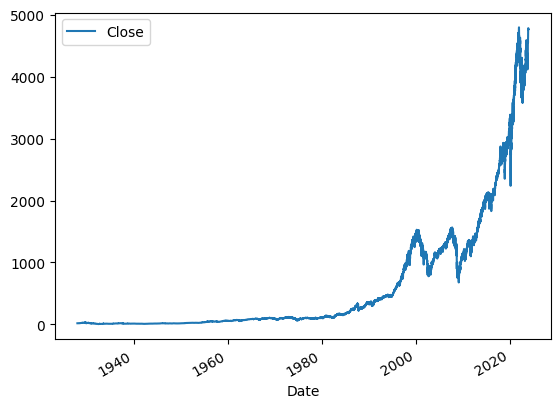

In [5]:
sp500.plot.line(y="Close", use_index=True)

Removing the columns that are appropriate for individual stocks not index

In [6]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [7]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [8]:
sp500

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000
...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,4753.919922,4772.939941,4736.770020,4754.629883,3046770000,4774.750000
2023-12-26 00:00:00-05:00,4758.859863,4784.720215,4758.450195,4774.750000,2513910000,4781.580078
2023-12-27 00:00:00-05:00,4773.450195,4785.390137,4768.899902,4781.580078,2748450000,4783.350098


In [9]:
sp500["Target"] = (sp500["Tomorrow"]> sp500["Close"]).astype(int)

In [10]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000,1
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000,1
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000,0
...,...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,4753.919922,4772.939941,4736.770020,4754.629883,3046770000,4774.750000,1
2023-12-26 00:00:00-05:00,4758.859863,4784.720215,4758.450195,4774.750000,2513910000,4781.580078,1
2023-12-27 00:00:00-05:00,4773.450195,4785.390137,4768.899902,4781.580078,2748450000,4783.350098,1


In [11]:
sp500 = sp500.loc["1990-01-01":].copy()

In [12]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,4753.919922,4772.939941,4736.770020,4754.629883,3046770000,4774.750000,1
2023-12-26 00:00:00-05:00,4758.859863,4784.720215,4758.450195,4774.750000,2513910000,4781.580078,1
2023-12-27 00:00:00-05:00,4773.450195,4785.390137,4768.899902,4781.580078,2748450000,4783.350098,1
